In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
#Utility Commands
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

# def to_gif(images, duration):
#   """Converts image sequence (4D numpy array) to gif."""
#   imageio.mimsave('./animation.gif', images, duration=duration)
#   return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [3]:
class PersonDetector:
    def __init__(self):
        model_path = "https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/singlepose-thunder/versions/4"
        self.movenet = self.load_model(model_path)
    
    def load_model(self,model_path):
        model = hub.load(model_path)
        movenet = model.signatures['serving_default']
        return movenet

    def get_model(self):
        return self.movenet
    
    def detect(self,input_image,inference_count=3):
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = self.movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

In [4]:
class ImageProcessor:
    def process_image(self,image_path):
        image = tf.io.read_file(image_path)
        image = tf.compat.v1.image.decode_jpeg(image)
        image = tf.expand_dims(image, axis=0)
        image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
        return image
    
    def display_image(self,image):
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(image[0])
        plt.show()
        
    def display_image_with_keypoints(self,image,keypoints):
        display_image = tf.cast(tf.image.resize_with_pad(
            image, 1280, 1280), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(
            np.squeeze(display_image.numpy(), axis=0), keypoints)
        plt.figure(figsize=(5, 5))
        plt.imshow(output_overlay)
        _ = plt.axis('off')

In [5]:
detector = PersonDetector()

In [6]:
imageProcessor = ImageProcessor()

In [7]:
def load_image(detector:PersonDetector,imageProcessor:ImageProcessor,path:str):
    keypoint_data = []
    image_label = []
    angle_data = []
    image_direction = []
    label_index = ["standing","jumpingjack","pushup","situp","squat","front","side"]
    direction_index = ["front","side"]
    for images in os.listdir(path):
        image = imageProcessor.process_image(os.path.join(path,images))
        keypoints = detector.detect(image)
        
        key = keypoints[0][0]
        
        keypoint_data.append(np.ndarray.flatten(keypoints[0][0]))
        label = images.split("_")
        image_label.append(label[1])
        image_direction.append(label[0])
        
        angle = calculate_angle(key)
        angle_data.append(angle)
    
        imageProcessor.display_image_with_keypoints(image,keypoints)

    angle_data = np.array(angle_data)
    
    result = pd.DataFrame()
    result["data"] = keypoint_data
    result["label_no"] = [label_index.index(label) for label in image_label]
    result["label"] = image_label
    result["direction_no"] = [direction_index.index(direction) for direction in image_direction]
    result["direction"] = image_direction
    result["right knee"] = angle_data.T[0]
    result["left knee"] = angle_data.T[1]
    result["right hip"] = angle_data.T[2]
    result["left hip"] = angle_data.T[3]
    result["right elbow"] = angle_data.T[4]
    result["left elbow"] = angle_data.T[5]
    
    return result

def calculate_angle(key):
    
    right_wrist = key[10]
    left_wrist = key[9]
    
    right_elbow = key[8]
    left_elbow = key[7]
    
    right_shoulder = key[6]
    left_shoulder = key[5]
    
    right_hip = key[12]
    left_hip = key[11]
    
    right_knee = key[14]
    left_knee = key[13]
    
    right_ankle = key[16]
    left_ankle = key[15]
    
    angle_right_we = np.degrees(np.arctan2(right_wrist[1] - right_elbow[1], right_wrist[0] - right_elbow[0]))
    angle_right_es = np.degrees(np.arctan2(right_elbow[1] - right_shoulder[1], right_elbow[0] - right_shoulder[0]))
    angle_right_sh = np.degrees(np.arctan2(right_shoulder[1] - right_hip[1], right_shoulder[0] - right_hip[0]))
    angle_right_hk = np.degrees(np.arctan2(right_hip[1] - right_knee[1], right_hip[0] - right_knee[0]))
    angle_right_ka = np.degrees(np.arctan2(right_knee[1] - right_ankle[1], right_knee[0] - right_ankle[0]))
    
    angle_left_we = np.degrees(np.arctan2(left_wrist[1] - left_elbow[1], left_wrist[0] - left_elbow[0]))
    angle_left_es = np.degrees(np.arctan2(left_elbow[1] - left_shoulder[1], left_elbow[0] - left_shoulder[0]))
    angle_left_sh = np.degrees(np.arctan2(left_shoulder[1] - left_hip[1], left_shoulder[0] - left_hip[0]))
    angle_left_hk = np.degrees(np.arctan2(left_hip[1] - left_knee[1], left_hip[0] - left_knee[0]))
    angle_left_ka = np.degrees(np.arctan2(left_knee[1] - left_ankle[1], left_knee[0] - left_ankle[0]))
    
    angles = [angle_right_we,angle_right_es,angle_right_sh,angle_right_hk,angle_right_ka,angle_left_we,angle_left_es,angle_left_sh,angle_left_hk,angle_left_ka]
    angles = [angle if angle > 0 else angle + 180 for angle in angles]
    
    right_knee_angle = abs(angles[3] - angles[4])
    left_knee_angle = abs(angles[8] - angles[9])
    
    right_hip_angle = abs(angles[2] - angles[3])
    left_hip_angle = abs(angles[7] - angles[8])
    
    right_elbow_angle = abs(angles[0] - angles[1])
    left_elbow_angle = abs(angles[5] - angles[6])
    
    angles = [right_knee_angle,left_knee_angle,right_hip_angle,left_hip_angle,right_elbow_angle,left_elbow_angle]
    
    return angles


,data,label_no,label,direction_no,direction,right knee,left knee,right hip,left hip,right elbow,left elbow
0,"[0.2732513, 0.5244943, 0.6393904, 0.26910827, ...",1,jumpingjack,0,front,14.748230,174.896271,166.140335,170.383804,105.764099,108.848389
1,"[0.45376098, 0.48722136, 0.7070878, 0.41500548...",2,pushup,0,front,75.839531,98.156036,22.197739,6.673859,113.109592,116.642859
2,"[0.4440593, 0.4816682, 0.58305025, 0.40359226,...",2,pushup,0,front,3.416550,109.128433,138.752823,134.283203,78.000111,79.428473
3,"[0.12098136, 0.4792457, 0.70843047, 0.10183596...",0,standing,0,front,1.406418,178.835190,169.897018,170.744934,150.305946,153.976275
4,"[0.21533872, 0.49773616, 0.7079618, 0.20129201...",0,standing,0,front,4.074570,169.134949,13.400375,166.692749,139.958893,139.380853
5,"[0.14249271, 0.51836205, 0.534998, 0.12823625,...",0,standing,0,front,2.298615,172.902664,0.412842,165.441299,3.329454,152.208441
6,"[0.33596694, 0.68260616, 0.8504348, 0.31488863...",3,situp,1,side,104.543549,119.700943,129.272919,125.591660,29.635178,71.356232
7,"[0.44970602, 0.5787002, 0.54177356, 0.43362832...",4,squat,1,side,74.978905,73.810417,70.462761,70.452278,110.265579,97.424210
8,"[0.31545112, 0.4347699, 0.4797381, 0.29878667,...",4,squat,1,side,80.720024,78.850189,55.190300,52.531372,14.791527,11.786301
9,"[0.14085707, 0.43970647, 0.54761577, 0.1257053...",0,standing,1,side,175.449188,2.109604,2.505341,178.152451,13.457443,15.677880


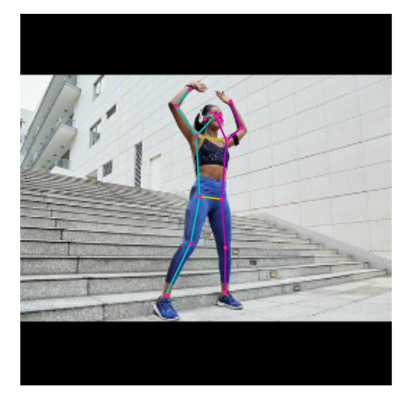

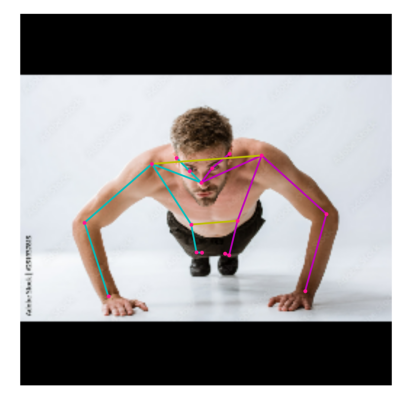

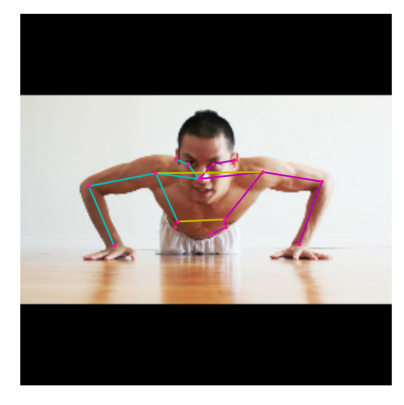

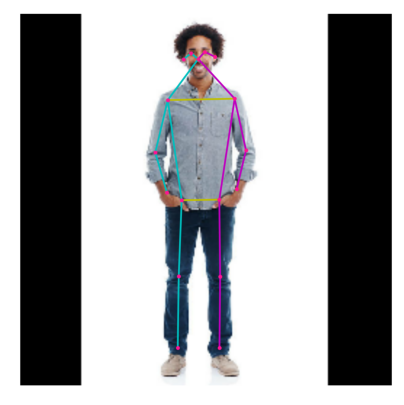

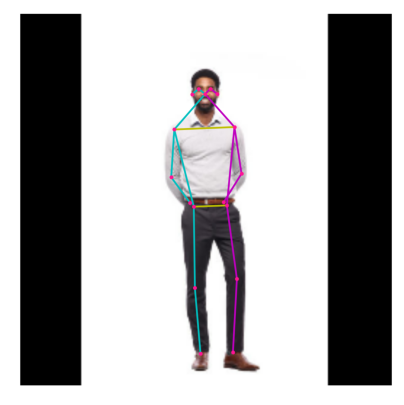

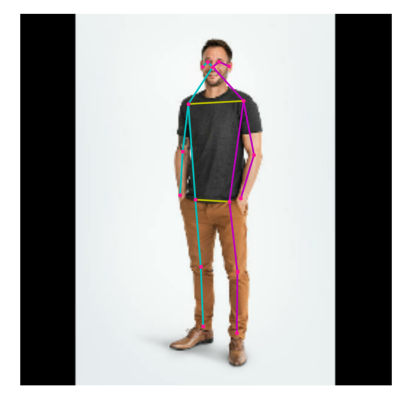

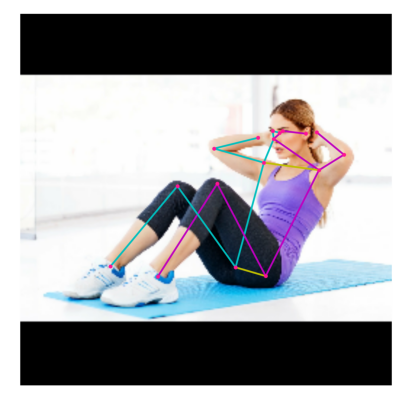

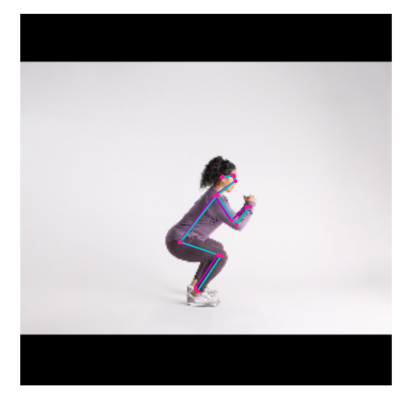

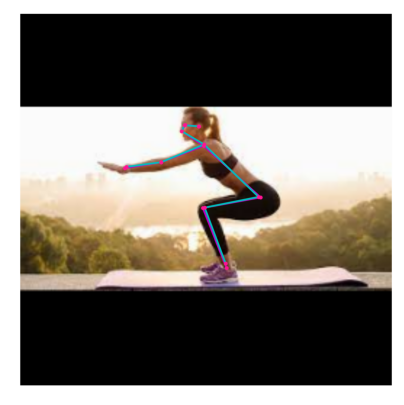

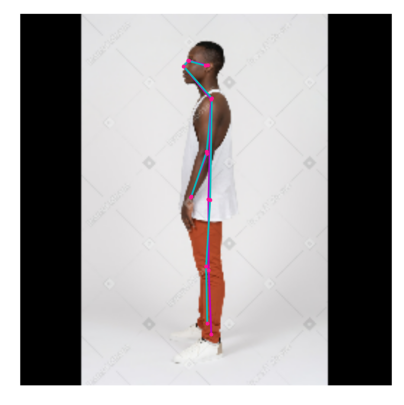

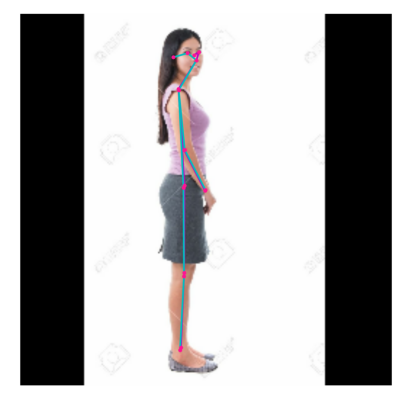

In [9]:
df2 = load_image(detector,imageProcessor,"../../Datasets/Trainer/workout")
df2

In [10]:
df2.to_csv("data.csv",index=False)

In [ ]:
class PoseData:
    def __init__(self,path):
        self.data = self.load_pose_data(path)
        
    def load_pose_data(self,path:str):
        data = pd.read_csv(path)
        return data
    
    def pose_landmarks(self,data):
        df = data.copy()
        

In [ ]:
data = pd.read_csv("data.csv")
df = data.copy()
df

,data,label_no,label,direction_no,direction,right knee,left knee,right hip,left hip,right elbow,left elbow
0,[0.2732513 0.5244943 0.6393904 0.26910827 0...,1,jumpingjack,0,front,14.748230,174.896271,166.140335,170.383804,105.764099,108.848389
1,[0.45376098 0.48722136 0.7070878 0.41500548 0...,2,pushup,0,front,75.839531,98.156036,22.197739,6.673859,113.109592,116.642859
2,[0.4440593 0.4816682 0.58305025 0.40359226 0...,2,pushup,0,front,3.416550,109.128433,138.752823,134.283203,78.000111,79.428473
3,[0.12098136 0.4792457 0.70843047 0.10183597 0...,0,standing,0,front,1.406418,178.835190,169.897018,170.744934,150.305946,153.976275
4,[0.21533872 0.49773616 0.7079618 0.20129201 0...,0,standing,0,front,4.074570,169.134949,13.400375,166.692749,139.958893,139.380853
5,[0.14249271 0.51836205 0.534998 0.12823625 0...,0,standing,0,front,2.298615,172.902664,0.412842,165.441299,3.329454,152.208441
6,[0.33596694 0.68260616 0.8504348 0.31488863 0...,3,situp,1,side,104.543549,119.700943,129.272919,125.591660,29.635178,71.356232
7,[0.44970602 0.5787002 0.54177356 0.43362832 0...,4,squat,1,side,74.978905,73.810417,70.462761,70.452278,110.265579,97.424210
8,[0.31545112 0.4347699 0.4797381 0.29878667 0...,4,squat,1,side,80.720024,78.850189,55.190300,52.531372,14.791527,11.786301
9,[0.14085707 0.43970647 0.54761577 0.12570536 0...,0,standing,1,side,175.449188,2.109604,2.505341,178.152451,13.457443,15.677880


In [11]:

def pose_landmarks(path):
    data = pd.read_csv(path)
    df = data.copy()
    classes = df.pop("label").unique()
    X = []
    temp_X = df.pop("data")
    for data in temp_X:
        spliited = data.replace("[","").replace("]","").replace("\n","").replace("  "," ").split(" ")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        X.append(data)
    y = df.pop("label_no")
    y = tf.keras.utils.to_categorical(y)
    direction_classes = df.pop("direction").unique()
    y_direction = df.pop("direction_no")
    y_direction = tf.keras.utils.to_categorical(y_direction)
    y_angle = df.copy()
    return X,y,y_direction,y_angle,classes,direction_classes

X,y,y_direction,y_angle,classes,direction_classes = pose_landmarks("data.csv")
X_train = tf.stack(X)
y_pose_train = tf.stack(y)
y_angle_train = tf.stack(y_angle)
y_direction_train = tf.stack(y_direction)

print(X)

[array([0.2732513 , 0.5244943 , 0.6393904 , 0.26910827, 0.5358587 ,
       0.51329833, 0.26459053, 0.5133002 , 0.27475154, 0.28756347,
       0.5419124 , 0.7293453 , 0.28152287, 0.4970794 , 0.46954367,
       0.34093755, 0.55529594, 0.6770681 , 0.3282333 , 0.4741251 ,
       0.6459189 , 0.3060862 , 0.5950337 , 0.5333322 , 0.24682112,
       0.4180989 , 0.66085404, 0.23464242, 0.5655817 , 0.59665567,
       0.20030089, 0.45672202, 0.58126783, 0.49827847, 0.5416975 ,
       0.7276768 , 0.49128374, 0.48280448, 0.71709466, 0.6282546 ,
       0.55233   , 0.57779074, 0.6164628 , 0.4588968 , 0.7618213 ,
       0.749832  , 0.55142367, 0.7643555 , 0.757896  , 0.3912522 ,
       0.7222185 ]), array([0.45376098, 0.48722136, 0.7070878 , 0.41500548, 0.5162464 ,
       0.8005116 , 0.42262852, 0.45599073, 0.7471473 , 0.3762543 ,
       0.5633066 , 0.7144606 , 0.3874747 , 0.42077163, 0.68145424,
       0.3808246 , 0.64998424, 0.90834117, 0.4034154 , 0.3544513 ,
       0.7792906 , 0.5381643 , 0.8243736

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data_input (InputLayer)     [(None, 51)]                 0         []                            
                                                                                                  
 dense_56 (Dense)            (None, 128)                  6656      ['data_input[0][0]']          
                                                                                                  
 dropout_34 (Dropout)        (None, 128)                  0         ['dense_56[0][0]']            
                                                                                                  
 dense_57 (Dense)            (None, 128)                  16512     ['dropout_34[0][0]']          
                                                                                           

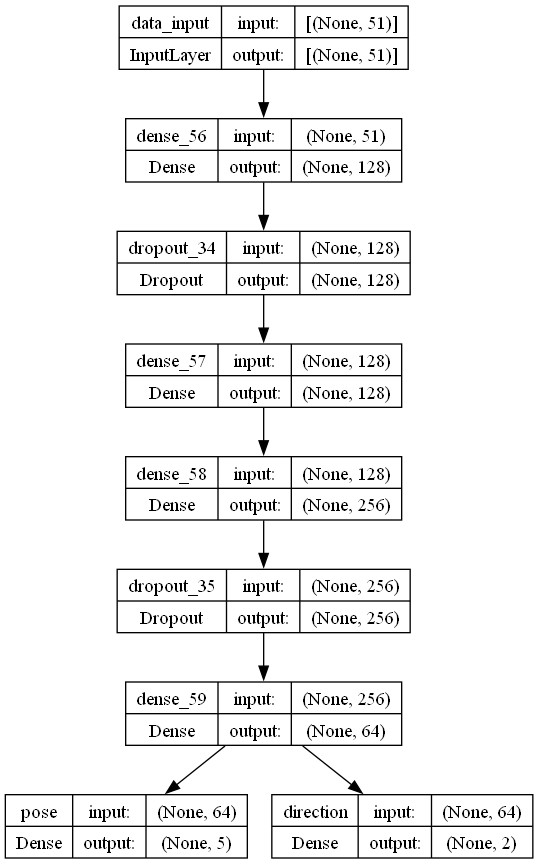

In [130]:
def landmark_to_embedding(landmark):
    
    embedding = tf.keras.layers.Reshape((17, 3))(landmark)
    return embedding

inputs = tf.keras.Input(shape=(51),name="data_input")
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(layer)
layer = tf.keras.layers.Dense(256, activation=tf.nn.relu6)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer2 = tf.keras.layers.Dense(256, activation=tf.nn.relu6)(layer)
outputs_1 = tf.keras.layers.Dense(5, activation="softmax",name="pose")(layer)
outputs_2 = tf.keras.layers.Dense(2, activation="softmax",name="direction")(layer)
# outputs_3 = tf.keras.layers.Dense(6,name="angle")(layer2)

model = tf.keras.Model(inputs, [outputs_1,outputs_2])
model.summary()
tf.keras.utils.plot_model(model, "model3.png", show_shapes=True)

In [140]:
class customcallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("loss") < 0.01:
            self.model.stop_training = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={"pose": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          "direction": tf.keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={"pose": 'accuracy',
             "direction": 'accuracy'}
)


history = model.fit(X_train, 
                    {"pose": y_pose_train,
                    "direction": y_direction_train},
                    callbacks=[customcallback()],
                    epochs=1000)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.1004 - pose_loss: 0.0383 - direction_loss: 0.0620 - pose_accuracy: 1.0000 - direction_accuracy: 1.0000
Epoch 2/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5227 - pose_loss: 0.3930 - direction_loss: 0.1297 - pose_accuracy: 0.9091 - direction_accuracy: 0.9091
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0835 - pose_loss: 0.0464 - direction_loss: 0.0370 - pose_accuracy: 1.0000 - direction_accuracy: 1.0000
Epoch 4/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.1194 - pose_loss: 0.0364 - direction_loss: 0.0831 - pose_accuracy: 1.0000 - direction_accuracy: 1.0000
Epoch 5/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.1919 - pose_loss: 0.0397 - direction_loss: 0.1523 - pose_accuracy: 1.0000 - direction_accuracy: 0.9091
Epoch 6/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.3360 - pose_loss: 0.1706 - direction_loss

In [90]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.fit(X_train, y_angle_train, epochs=1000)
###??????????? HOW TO Improve T.T


Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 11779.2822 - accuracy: 0.1818
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 11772.3477 - accuracy: 0.1818
Epoch 3/1000
1/1 [==============================] - 0s 9ms/step - loss: 11774.3301 - accuracy: 0.1818
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 11774.1553 - accuracy: 0.1818
Epoch 5/1000
1/1 [==============================] - 0s 8ms/step - loss: 11768.0273 - accuracy: 0.1818
Epoch 6/1000
1/1 [==============================] - 0s 7ms/step - loss: 11764.8896 - accuracy: 0.2727
Epoch 7/1000
1/1 [==============================] - 0s 9ms/step - loss: 11761.7871 - accuracy: 0.1818
Epoch 8/1000
1/1 [==============================] - 0s 10ms/step - loss: 11760.9883 - accuracy: 0.1818
Epoch 9/1000
1/1 [==============================] - 0s 9ms/step - loss: 11763.9482 - accuracy: 0.0909
Epoch 10/1000
1/1 [==============================] - 0s 8ms/step - loss: 11755.674

In [128]:
print(X_train.shape)
print(y_angle.shape)

(11, 51)
(11, 6)


In [147]:
a = model.predict(tf.expand_dims(X[0],axis=0))
print("Data :")
print(X[0])
print(f"Label : {classes[np.argmax(a[0])]}")
print(f"Direction : {direction_classes[np.argmax(a[1])]}")
print(a)

[0.2732513  0.5244943  0.6393904  0.26910827 0.5358587  0.51329833
 0.26459053 0.5133002  0.27475154 0.28756347 0.5419124  0.7293453
 0.28152287 0.4970794  0.46954367 0.34093755 0.55529594 0.6770681
 0.3282333  0.4741251  0.6459189  0.3060862  0.5950337  0.5333322
 0.24682112 0.4180989  0.66085404 0.23464242 0.5655817  0.59665567
 0.20030089 0.45672202 0.58126783 0.49827847 0.5416975  0.7276768
 0.49128374 0.48280448 0.71709466 0.6282546  0.55233    0.57779074
 0.6164628  0.4588968  0.7618213  0.749832   0.55142367 0.7643555
 0.757896   0.3912522  0.7222185 ]
1/1 [==============================] - 0s 25ms/step
Data :
[0.2732513  0.5244943  0.6393904  0.26910827 0.5358587  0.51329833
 0.26459053 0.5133002  0.27475154 0.28756347 0.5419124  0.7293453
 0.28152287 0.4970794  0.46954367 0.34093755 0.55529594 0.6770681
 0.3282333  0.4741251  0.6459189  0.3060862  0.5950337  0.5333322
 0.24682112 0.4180989  0.66085404 0.23464242 0.5655817  0.59665567
 0.20030089 0.45672202 0.58126783 0.4982784

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo0qx4te6\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpo0qx4te6\assets


Model size: 49KB
